<h1>training phrase</h1>

In [1]:
import pandas as pd

In [2]:
df_train=pd.read_csv('data/train.csv')

In [4]:
print(df_train.head())

         date  calls   weekday  reservations_2months_advance  \
0  2014-01-31   2477    Friday                          2906   
1  2014-02-01   1600  Saturday                          1360   
2  2014-02-02   1310    Sunday                          1552   
3  2014-02-03   2673    Monday                          2135   
4  2014-02-04   2460   Tuesday                          2207   

   total_reservations  summer_break  christmas_break  special_day  dayofweek  \
0               13759             0                0            0          4   
1                9498             0                0            0          5   
2                7815             0                0            0          6   
3               15401             0                0            0          0   
4               13840             0                0            0          1   

   quarter  ...  reservations_ratio  calls_per_reservation  sin_dayofyear  \
0        1  ...            0.211192               0.18001

In [3]:
df_train.head()
df_train.info()
df_train.describe()
df_train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 59 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          608 non-null    object 
 1   calls                         608 non-null    int64  
 2   weekday                       608 non-null    object 
 3   reservations_2months_advance  608 non-null    int64  
 4   total_reservations            608 non-null    int64  
 5   summer_break                  608 non-null    int64  
 6   christmas_break               608 non-null    int64  
 7   special_day                   608 non-null    int64  
 8   dayofweek                     608 non-null    int64  
 9   quarter                       608 non-null    int64  
 10  month                         608 non-null    int64  
 11  year                          608 non-null    int64  
 12  calls_lag_1                   608 non-null    float64
 13  total

date                            0
calls                           0
weekday                         0
reservations_2months_advance    0
total_reservations              0
summer_break                    0
christmas_break                 0
special_day                     0
dayofweek                       0
quarter                         0
month                           0
year                            0
calls_lag_1                     0
total_reservations_lag_1        0
reservations_2months_lag_1      0
calls_lag_7                     0
total_reservations_lag_7        0
reservations_2months_lag_7      0
calls_lag_14                    0
total_reservations_lag_14       0
reservations_2months_lag_14     0
calls_lag_30                    0
total_reservations_lag_30       0
reservations_2months_lag_30     0
calls_roll_mean_7               0
calls_roll_std_7                0
calls_roll_min_7                0
calls_roll_max_7                0
reservations_roll_mean_7        0
reservations_r

<h1>start forecasting</h1>

In [5]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

c:\isuru_dd\tellcolll\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [6]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [7]:
train_df=df_train.copy()

In [8]:
#convert date to datetime
train_df['date']=pd.to_datetime(train_df['date'])

In [9]:
# Use last 20% of training data for validation (approximately 122 days)
val_size = int(len(train_df) * 0.2)
train_data = train_df.iloc[:-val_size].copy()
val_data = train_df.iloc[-val_size:].copy()

print(f"Train set: {len(train_data)} days ({train_data['date'].min()} to {train_data['date'].max()})")
print(f"Validation set: {len(val_data)} days ({val_data['date'].min()} to {val_data['date'].max()})")

Train set: 487 days (2014-01-31 00:00:00 to 2015-06-01 00:00:00)
Validation set: 121 days (2015-06-02 00:00:00 to 2015-09-30 00:00:00)


In [10]:
# Prophet requires 'ds' (date) and 'y' (target) columns
prophet_train = pd.DataFrame({
    'ds': train_data['date'],
    'y': train_data['calls']
})

In [11]:
# Add relevant regressors - selecting most important features
# Avoid lag features and rolling stats as they would need complex future calculations
regressors = [
    'total_reservations',
    'reservations_2months_advance',
    'summer_break',
    'christmas_break',
    'special_day',
    'is_weekend',
    'dayofweek',
    'month',
    'quarter'
]

In [12]:
for reg in regressors:
    prophet_train[reg] = train_data[reg].values

print(f"Prophet training dataframe shape: {prophet_train.shape}")
print(f"Regressors included: {regressors}")

Prophet training dataframe shape: (487, 11)
Regressors included: ['total_reservations', 'reservations_2months_advance', 'summer_break', 'christmas_break', 'special_day', 'is_weekend', 'dayofweek', 'month', 'quarter']


In [13]:
# Initialize Prophet with tuned parameters
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',  # Try 'additive' if multiplicative doesn't work well
    changepoint_prior_scale=0.05,  # Flexibility of trend (0.001-0.5, lower = less flexible)
    seasonality_prior_scale=10,  # Flexibility of seasonality (default=10)
    holidays_prior_scale=10,  # Flexibility of holiday effects
    changepoint_range=0.9,  # Proportion of history for trend changepoints
    interval_width=0.95  # Uncertainty intervals
)

In [14]:
# Add regressors to the model
for reg in regressors:
    model.add_regressor(reg)

In [15]:
#fit the model
model.fit(prophet_train)

14:39:25 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# Prepare validation dataframe
prophet_val = pd.DataFrame({
    'ds': val_data['date']
})

In [17]:
for reg in regressors:
    prophet_val[reg] = val_data[reg].values

In [18]:
# Make predictions on validation set
val_forecast = model.predict(prophet_val)
val_predictions = val_forecast['yhat'].values
val_actual = val_data['calls'].values

In [20]:
import numpy as np

In [21]:
# Calculate validation metrics
val_mae = mean_absolute_error(val_actual, val_predictions)
val_rmse = np.sqrt(mean_squared_error(val_actual, val_predictions))
val_mape = mean_absolute_percentage_error(val_actual, val_predictions) * 100

In [22]:
print(f"  MAE:  {val_mae:.2f}")
print(f"  RMSE: {val_rmse:.2f}")
print(f"  MAPE: {val_mape:.2f}%")

  MAE:  255.92
  RMSE: 322.60
  MAPE: 3.31%


In [23]:
prophet_full_train = pd.DataFrame({
    'ds': train_df['date'],
    'y': train_df['calls']
})

In [24]:
for reg in regressors:
    prophet_full_train[reg] = train_df[reg].values


In [25]:
final_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10,
    holidays_prior_scale=10,
    changepoint_range=0.9,
    interval_width=0.95
)

In [26]:
for reg in regressors:
    final_model.add_regressor(reg)

In [27]:
final_model.fit(prophet_full_train)

15:05:55 - cmdstanpy - INFO - Chain [1] start processing
15:06:15 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
# Generate future dates
last_train_date = train_df['date'].max()
future_dates = pd.date_range(start=last_train_date + timedelta(days=1), periods=152, freq='D')


In [29]:
future_df = pd.DataFrame({'ds': future_dates})

In [30]:
# Engineer features for future dates
future_df['dayofweek'] = future_df['ds'].dt.dayofweek
future_df['month'] = future_df['ds'].dt.month
future_df['quarter'] = future_df['ds'].dt.quarter
future_df['is_weekend'] = (future_df['dayofweek'] >= 5).astype(int)
future_df['dayofyear'] = future_df['ds'].dt.dayofyear

In [31]:
# Special periods (you may need to adjust these dates based on your domain)
# Summer break: assume June-August (months 6,7,8)
future_df['summer_break'] = future_df['month'].isin([6, 7, 8]).astype(int)

# Christmas break: assume mid-December to early January (adjust as needed)
future_df['christmas_break'] = ((future_df['month'] == 12) & (future_df['ds'].dt.day >= 20) | 
                                 (future_df['month'] == 1) & (future_df['ds'].dt.day <= 5)).astype(int)

# Special days: you'll need to define these based on your domain knowledge
# For now, setting to 0 (no special days)
future_df['special_day'] = 0

# For reservations features, use historical averages by day of week and month
# This is a simple approach - you might want to use more sophisticated methods
train_avg_by_dow_month = train_df.groupby(['dayofweek', 'month']).agg({
    'total_reservations': 'mean',
    'reservations_2months_advance': 'mean'
}).reset_index()

In [32]:
# Merge averages
future_df = future_df.merge(train_avg_by_dow_month, on=['dayofweek', 'month'], how='left')


In [33]:
# Fill any missing values with overall mean
future_df['total_reservations'].fillna(train_df['total_reservations'].mean(), inplace=True)
future_df['reservations_2months_advance'].fillna(train_df['reservations_2months_advance'].mean(), inplace=True)

print(f"Future dataframe created with {len(future_df)} days")
print(f"Date range: {future_df['ds'].min()} to {future_df['ds'].max()}")


Future dataframe created with 152 days
Date range: 2015-10-01 00:00:00 to 2016-02-29 00:00:00


In [34]:
#make forecast for 152 days
forecast = final_model.predict(future_df)

# Extract predictions
forecast_results = pd.DataFrame({
    'date': forecast['ds'],
    'predicted_calls': forecast['yhat'],
    'lower_bound': forecast['yhat_lower'],
    'upper_bound': forecast['yhat_upper']
})

In [35]:
print(forecast_results.head(10))

        date  predicted_calls  lower_bound  upper_bound
0 2015-10-01      4194.033862  3850.594012  4556.410740
1 2015-10-02      4037.849825  3701.160703  4386.887096
2 2015-10-03      3149.689873  2773.797130  3518.194257
3 2015-10-04      2261.733434  1875.768094  2600.781012
4 2015-10-05      4255.475548  3888.305899  4614.392611
5 2015-10-06      4083.822331  3761.194070  4437.816658
6 2015-10-07      4216.462993  3859.758109  4585.039910
7 2015-10-08      4152.920109  3802.814868  4485.459171
8 2015-10-09      4005.594128  3630.086119  4364.860230
9 2015-10-10      3125.799958  2782.112167  3476.629037


In [36]:
# Save forecast results
forecast_results.to_csv('data\prophet_forecast_152days.csv', index=False)

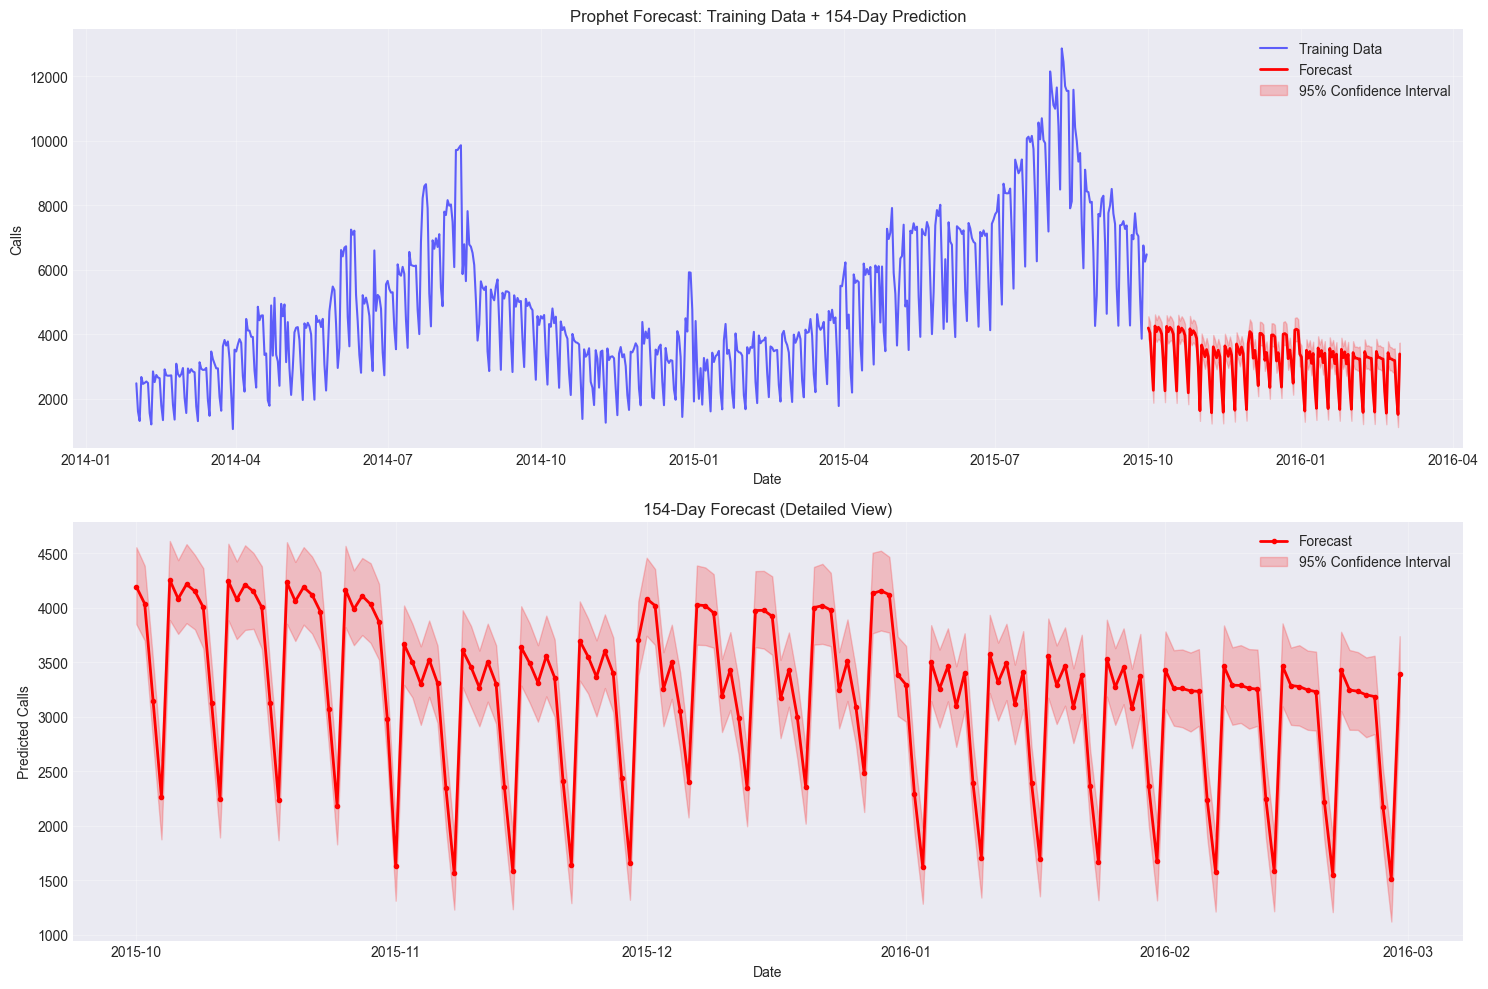

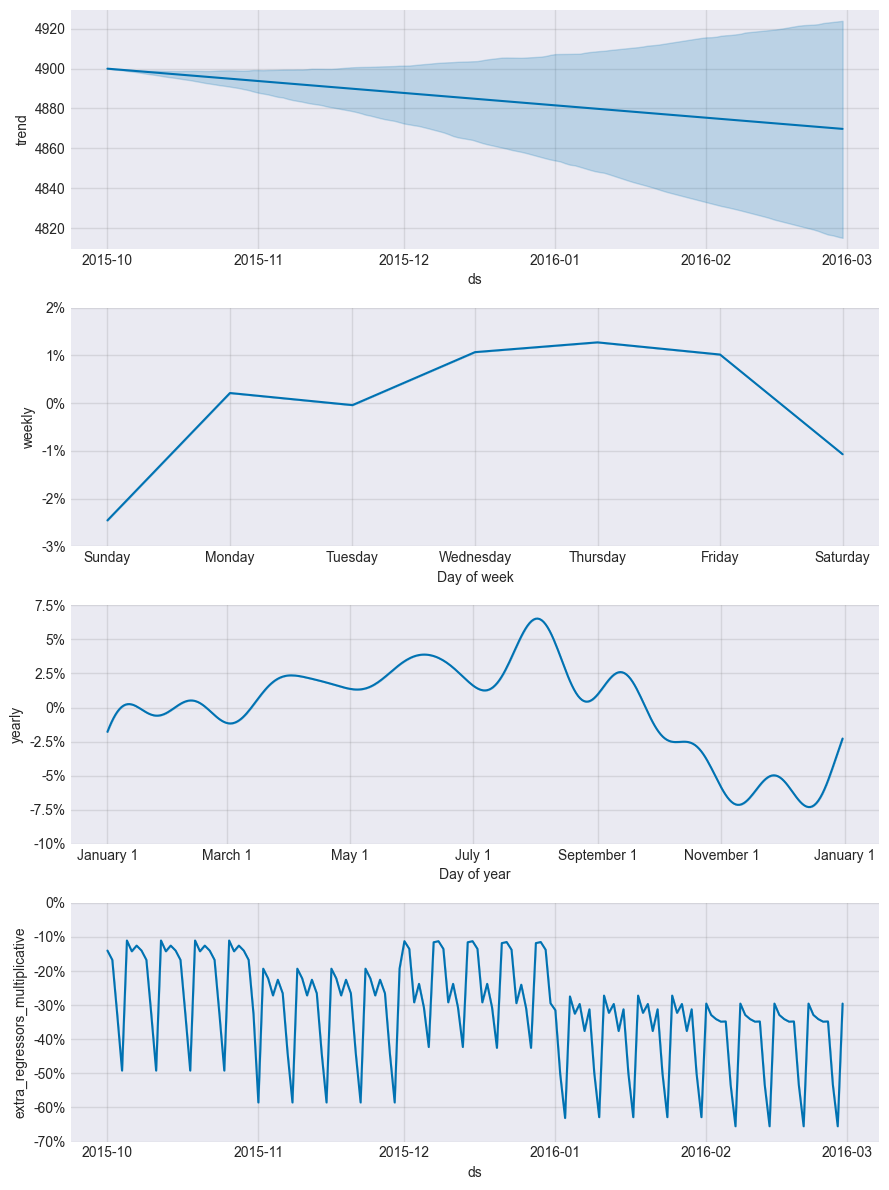

In [37]:
#visualize forecast
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Full forecast
ax1 = axes[0]
ax1.plot(train_df['date'], train_df['calls'], label='Training Data', color='blue', alpha=0.6)
ax1.plot(forecast_results['date'], forecast_results['predicted_calls'], 
         label='Forecast', color='red', linewidth=2)
ax1.fill_between(forecast_results['date'], 
                  forecast_results['lower_bound'], 
                  forecast_results['upper_bound'], 
                  alpha=0.2, color='red', label='95% Confidence Interval')
ax1.set_xlabel('Date')
ax1.set_ylabel('Calls')
ax1.set_title('Prophet Forecast: Training Data + 154-Day Prediction')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Forecast only (zoomed in)
ax2 = axes[1]
ax2.plot(forecast_results['date'], forecast_results['predicted_calls'], 
         label='Forecast', color='red', linewidth=2, marker='o', markersize=3)
ax2.fill_between(forecast_results['date'], 
                  forecast_results['lower_bound'], 
                  forecast_results['upper_bound'], 
                  alpha=0.2, color='red', label='95% Confidence Interval')
ax2.set_xlabel('Date')
ax2.set_ylabel('Predicted Calls')
ax2.set_title('154-Day Forecast (Detailed View)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot Prophet components
fig = final_model.plot_components(forecast)
plt.show()

